# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2025/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: 
 - The assignment is due on Monday March 31st, 2025 at 23:55. 
 - Hand via DTU Learn. 
 - You should simply hand in the link to the github page with your short data story.

## A2: A short data story

This assignment is to create a short data-story based on the work we've done in class so far. See **Exercises Week 8, Part 2** for full details on how the story should be constructed.

In [19]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import math
import seaborn as sns
from scipy.stats import probplot

import warnings
warnings.filterwarnings('ignore')

In [20]:
# read the dataset
data = pd.read_csv('data/police_incidents.csv')

# define the 10 focus crimes
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY'])

# filter the data to only include the focus crimes
data_focus = data[data['Incident Category'].isin(focuscrimes)]

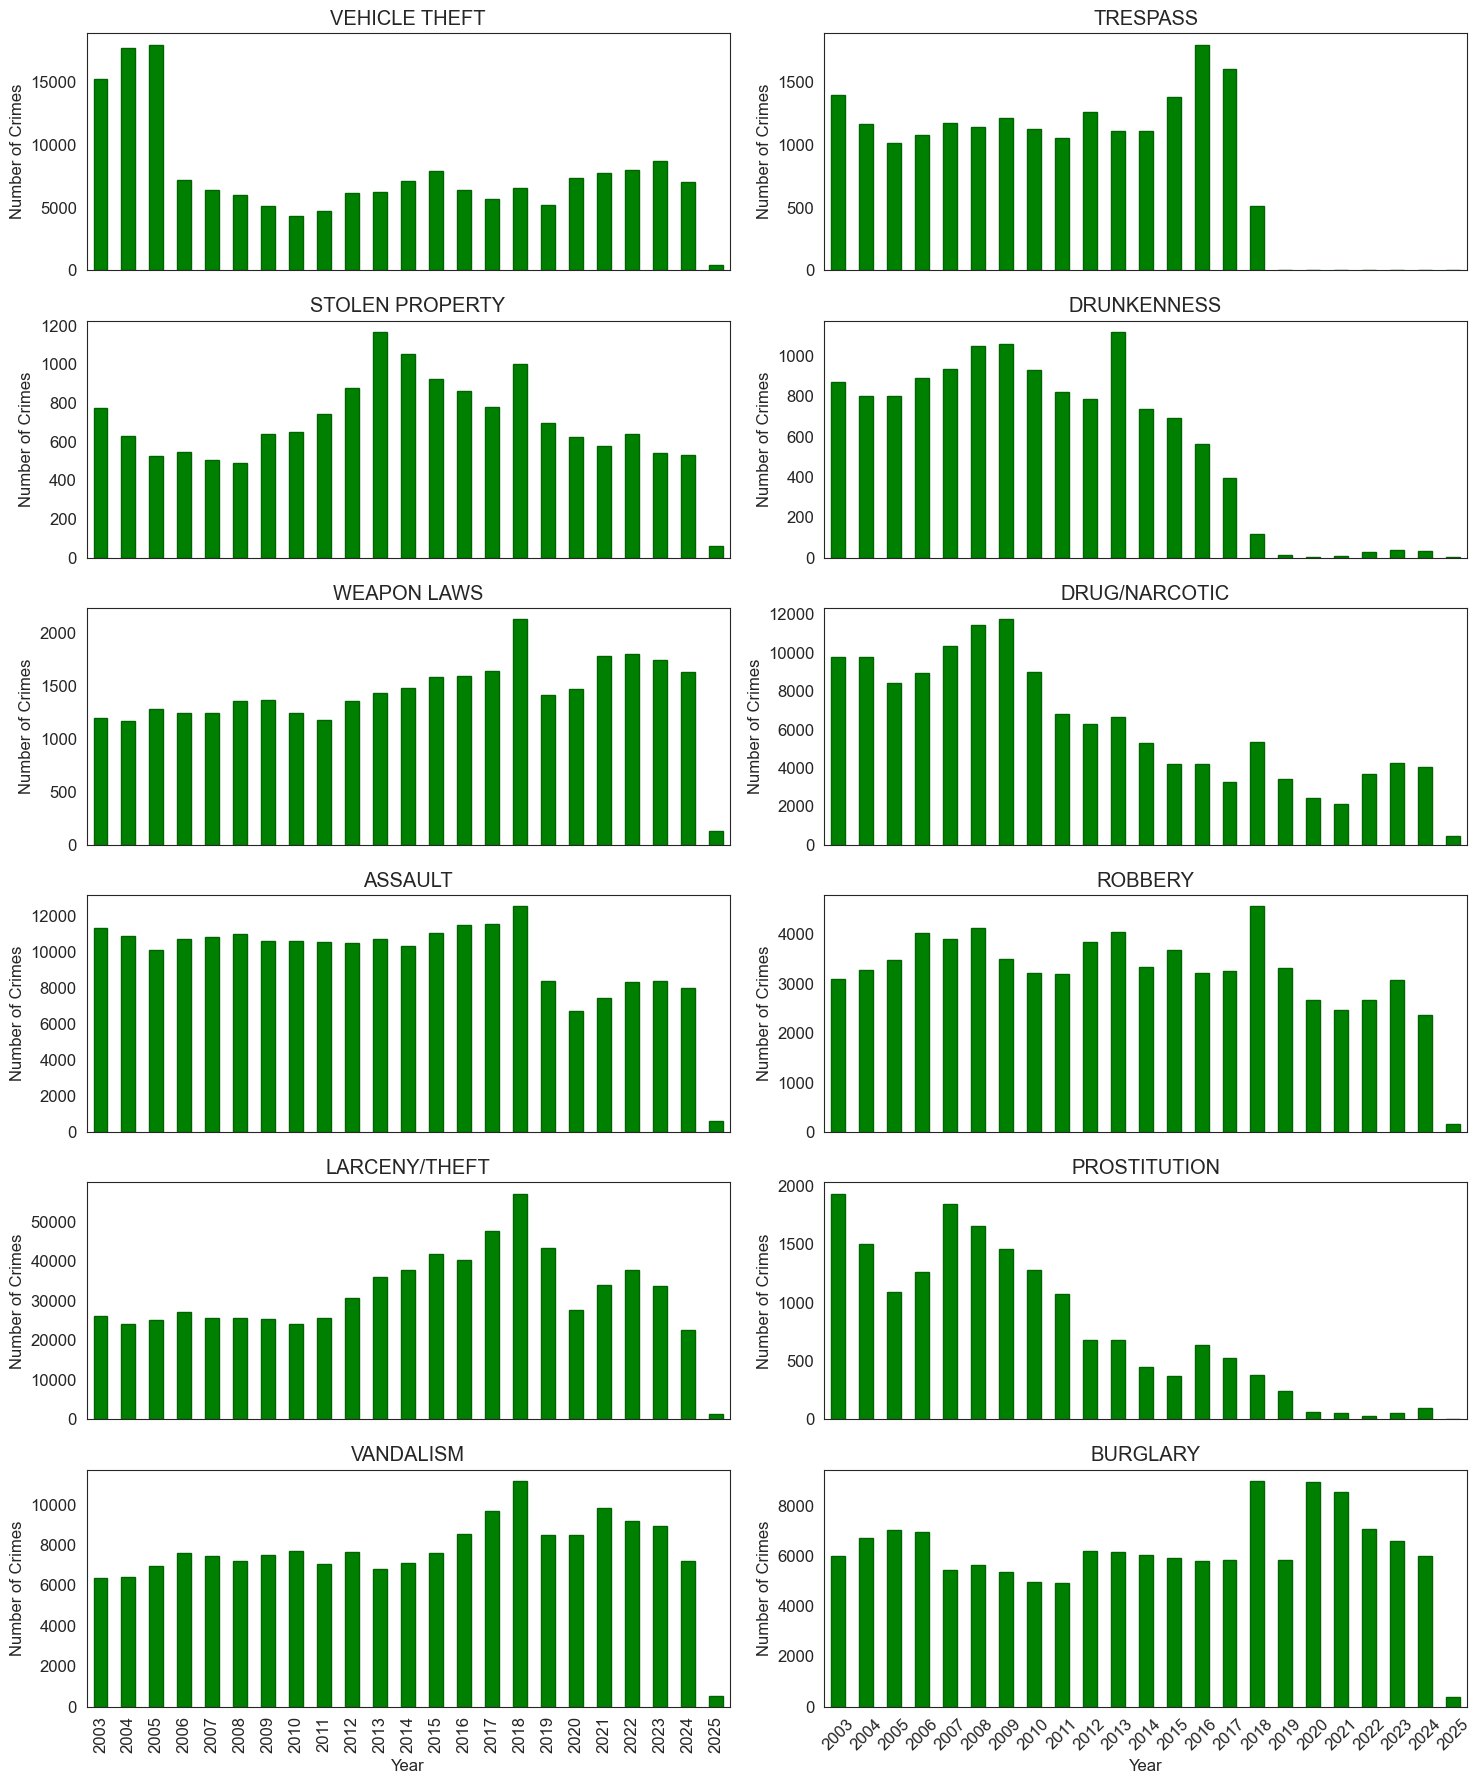

In [21]:
# Group data by category and year
category_year_counts = data_focus.groupby('Incident Category')['Incident Year'].value_counts().unstack()

# Define the number of rows and columns of the subplots
num_cols = 2
num_categories = len(focuscrimes)
num_rows = math.ceil(num_categories / num_cols)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows), sharex=True)
axes = axes.flatten()

for i, category in enumerate(focuscrimes):
    category_year_counts.loc[category].plot(kind='bar', ax=axes[i], color = 'green', edgecolor='darkgreen')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Number of Crimes')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


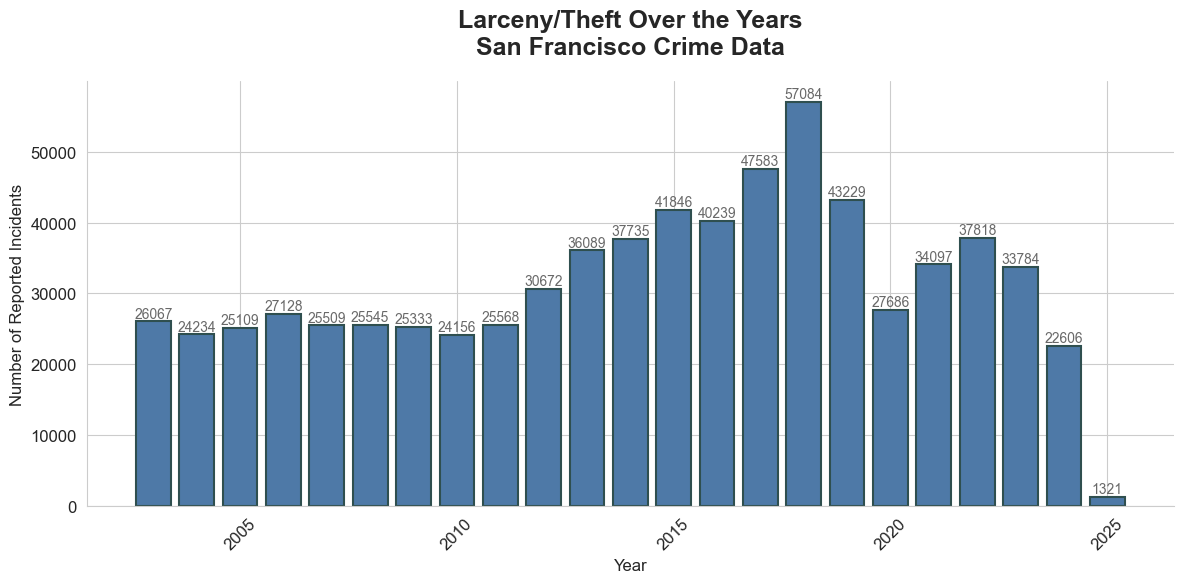

In [22]:
larceny_data = data_focus[data_focus['Incident Category'] == 'LARCENY/THEFT']

# Contar incidentes por año
larceny_counts = larceny_data['Incident Year'].value_counts().sort_index()

# Estilo visual tipo revista
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Crear el gráfico
bars = plt.bar(larceny_counts.index, larceny_counts.values,
               color="#4E79A7", edgecolor="#2F4F4F", linewidth=1.5)

# Título con personalidad
plt.title("Larceny/Theft Over the Years\nSan Francisco Crime Data", fontsize=18, weight='bold', pad=20)

# Etiquetas
plt.xlabel("Year")
plt.ylabel("Number of Reported Incidents", fontsize=12)
plt.xticks(rotation=45)

# Agregar valores encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 100,
             f'{int(height)}',
             ha='center',
             va='bottom',
             fontsize=10,
             color='dimgray')

# Quitar bordes innecesarios
sns.despine()

# Ajuste final
plt.tight_layout()
plt.show()

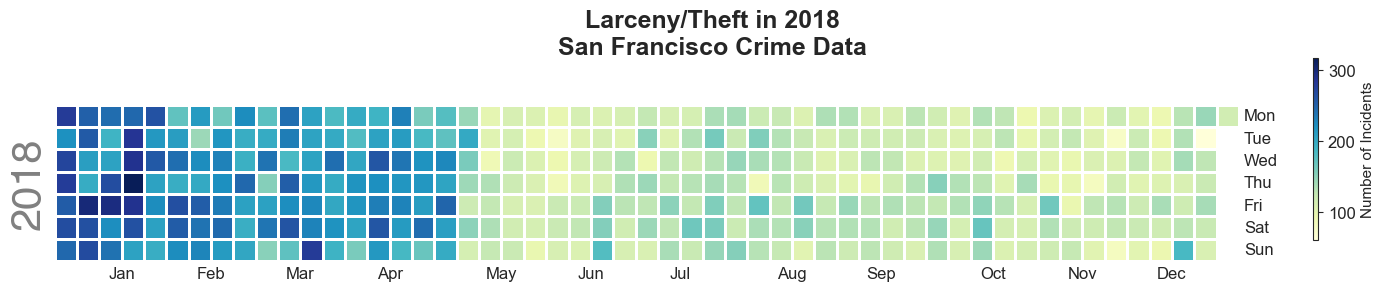

In [23]:
import calplot

theft_data = data_focus[data_focus["Incident Category"] == "LARCENY/THEFT"].copy()
theft_data['Incident Date'] = pd.to_datetime(theft_data['Incident Date'])
daily_counts = theft_data[theft_data['Incident Date'].dt.year == 2018].groupby('Incident Date').size()
sns.set_style("white")
plt.rcParams.update({'font.size': 12})

fig, ax = calplot.calplot(
    daily_counts,
    how='sum',
    cmap='YlGnBu',
    colorbar=False,  
    suptitle=None,
    figsize=(16, 4),
    dropzero=False,
    linewidth=1,
    edgecolor='white'
)

sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=daily_counts.min(), vmax=daily_counts.max()))
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(),
                    orientation='vertical',
                    shrink=0.5,      # Tamañobarra
                    pad=-0.35,        # Separación horizontal 
                    aspect=35)       # Proporción (alto-ancho) 

cbar.set_label('Number of Incidents', fontsize=11)

plt.suptitle("Larceny/Theft in 2018\nSan Francisco Crime Data",
             fontsize=18,
             weight='bold',
             x=0.45,
             y=0.85)

plt.tight_layout()
plt.show()

In [24]:
sf_lat, sf_lon = 37.7749, -122.4194
sf_map = folium.Map(location=[sf_lat, sf_lon], zoom_start=13)

In [25]:
data_focus["Incident Category"].unique()

array(['ASSAULT', 'BURGLARY', 'LARCENY/THEFT', 'TRESPASS', 'ROBBERY',
       'DRUG/NARCOTIC', 'DRUNKENNESS', 'VANDALISM', 'WEAPON LAWS',
       'VEHICLE THEFT', 'PROSTITUTION', 'STOLEN PROPERTY'], dtype=object)

In [26]:
# --- 1. Filtrar solo 2018 y Larceny/Theft ---
data_2018 = data_focus[
    (data_focus["Incident Category"].str.lower() == "larceny/theft") &
    (pd.to_datetime(data_focus["Incident Date"]).dt.year == 2018)
].copy()
data_2018["Incident Date"] = pd.to_datetime(data_2018["Incident Date"])
data_2018["Month"] = data_2018["Incident Date"].dt.strftime("%b")
data_2018["Month_Num"] = data_2018["Incident Date"].dt.month

Aqui voy a hacer merge de las caegorias que sean similares en incident category - incident description

Here we create 7 different groups with theft categories within the incident descriptions

In [27]:
def map_theft_category(description):
    desc = description.lower()
    
    if any(word in desc for word in ["auto", "vehicle strip", "motorcycle", "license plate", "burglary, vehicle", "from locked vehicle","from unlocked vehicle"]):
        return "Auto Theft / Vehicle Strip"
    elif "shoplift" in desc:
        return "Shoplifting"
    elif "bicycle" in desc:
        return "Bicycle Theft"
    elif any(word in desc for word in ["from person", "from building", "from unlocked", "from locked","pickpocket", "purse snatch", "computers","cell phones", "agricultural"]):
        return "Theft from Person / Building"
    elif any(word in desc for word in ["property"]):
        return "Property"
    elif any(word in desc for word in ["embezzlement", "fiduciary", "checks", "credit card", "telecom", "utility", "short change", "coin"]):
        return "Fraud / Embezzlement"
    else:
        return "Other / Unclassified"

data_2018["Theft Category"] = data_2018["Incident Description"].apply(map_theft_category)
data_2018

,Incident Number,Incident Code,Incident Category,Incident Description,Incident Day of Week,Incident Date,Incident Time,Police District,Resolution,Address,...,Current Police Districts,Current Supervisor Districts,Incident Month,Incident Month Name,Incident Year,Incident Hour,Incident Minute,Month,Month_Num,Theft Category
1107831,180071349,6373,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Wednesday,2018-01-24,15:46,PARK,NONE,0 Block of DELMAR ST,...,7.0,11.0,1,January,2018,15,46,Jan,1,Property
1112345,180338707,6361,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Monday,2018-05-07,10:23,SOUTHERN,NONE,700 Block of MARKET ST,...,5.0,10.0,5,May,2018,10,23,May,5,Shoplifting
1153307,186034662,6372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Sunday,2018-01-14,15:00,INGLESIDE,NONE,2200 Block of CAYUGA AV,...,9.0,1.0,1,January,2018,15,0,Jan,1,Property
1160838,186025019,6244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Saturday,2018-01-27,22:00,NORTHERN,NONE,VANNESS AV / SUTTER ST,...,4.0,6.0,1,January,2018,22,0,Jan,1,Auto Theft / Vehicle Strip
1162133,186006815,6244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,2018-01-07,11:00,INGLESIDE,NONE,600 Block of MYRA WY,...,9.0,8.0,1,January,2018,11,0,Jan,1,Auto Theft / Vehicle Strip
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953253,200517873,6381,LARCENY/THEFT,EMBEZZLEMENT FROM DEPENDENT OR ELDER ADULT BY ...,Friday,2018-08-17,12:00,BAYVIEW,Open or Active,REBECCA LN \ KEITH ST,...,2.0,9.0,8,August,2018,12,0,Aug,8,Fraud / Embezzlement
2962122,206098778,6374,LARCENY/THEFT,"THEFT, OTHER PROPERTY, >$950",Thursday,2018-07-19,17:00,NORTHERN,Open or Active,SCOTT ST \ GOLDEN GATE AVE,...,4.0,11.0,7,July,2018,17,0,Jul,7,Property
2971158,190202001,6374,LARCENY/THEFT,"THEFT, OTHER PROPERTY, >$950",Wednesday,2018-03-07,07:00,NORTHERN,Open or Active,PAGE ST \ PIERCE ST,...,4.0,11.0,3,March,2018,7,0,Mar,3,Property
2977994,220038445,27090,LARCENY/THEFT,"THEFT, LOST PROPERTY, PETTY",Sunday,2018-06-10,09:30,CENTRAL,Open or Active,GEARY ST \ POWELL ST,...,6.0,3.0,6,June,2018,9,30,Jun,6,Property


In [28]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category10
from bokeh.transform import factor_cmap
from bokeh.layouts import column

output_notebook()

Loading BokehJS ...

Bokah interactive graph: Y= number of crimes, X= months in 2018 , Categories= thft categories within inident description in theft/larceny

In [29]:
grouped = data_2018.groupby(["Month_Num", "Month", "Theft Category"]).size().reset_index(name="Count")
grouped = grouped.sort_values("Month_Num")

pivot = grouped.pivot(index='Month', columns='Theft Category', values='Count').fillna(0)
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
pivot = pivot.reindex(month_order)  # Asegura orden de meses

source = ColumnDataSource(pivot)

categories = pivot.columns.tolist()
colors = Category10[len(categories)]

p = figure(x_range=month_order,
           height=500,
           width=900,
           title="Larceny/Theft in San Francisco (2018) – Stacked by Category",
           toolbar_location="above",
           tools="pan,wheel_zoom,box_zoom,reset,save")

renderers = p.vbar_stack(
    categories,
    x='Month',
    width=0.9,
    color=colors,
    source=source,
    legend_label=categories,
    line_color="white"
)

hover = HoverTool(tooltips=[
    ("Month", "@Month"),
    ("Category", "$name"),
    ("Count", "@$name")
])
p.add_tools(hover)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.legend.location = "top_right"
p.legend.click_policy = "hide"  #interactivo

p.xaxis.axis_label = "Month"
p.yaxis.axis_label = "Number of Crimes"

show(p)



In [30]:
district_counts = data_2018["Police District"].value_counts()

print("Número de Auto Theft / Vehicle Strip por distrito en 2018:")
print(district_counts)

Número de Auto Theft / Vehicle Strip por distrito en 2018:
Police District
CENTRAL       12388
NORTHERN      10414
SOUTHERN       8350
MISSION        7052
RICHMOND       3712
TARAVAL        3585
BAYVIEW        3384
TENDERLOIN     2993
INGLESIDE      2600
PARK           2465
OUT OF SF       141
Name: count, dtype: int64


In [31]:
from folium.plugins import HeatMapWithTime


#  distritos
district_coords = {
    "CENTRAL":     [37.7964, -122.4083],
    "SOUTHERN":    [37.7780, -122.4075],
    "MISSION":     [37.7599, -122.4184],
    "BAYVIEW":     [37.7294, -122.3929],
    "RICHMOND":    [37.7799, -122.4721],
    "TARAVAL":     [37.7432, -122.4871],
    "INGLESIDE":   [37.7210, -122.4440],
    "PARK":        [37.7670, -122.4520],
    "TENDERLOIN":  [37.7850, -122.4155],
    "NORTHERN":    [37.7865, -122.4321],
    "OUT OF SF":   [37.6879, -122.4702]
}

for district, coords in district_coords.items():
    folium.CircleMarker(
        location=coords,
        radius=6,
        color='black',
        fill=True,
        fill_color='white',
        fill_opacity=0.9,
        popup=f"{district}",
        tooltip=f"{district}"
    ).add_to(sf_map)

filtered_data = data_2018[data_2018["Theft Category"].str.contains("Auto Theft / Vehicle Strip", case=False, na=False)]
filtered_data = filtered_data.dropna(subset=["Police District", "Latitude", "Longitude"])

filtered_data["Incident Date"] = pd.to_datetime(filtered_data["Incident Date"])
filtered_data["Month"] = filtered_data["Incident Date"].dt.strftime('%b')
filtered_data["Month_Num"] = filtered_data["Incident Date"].dt.month

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

heat_data_by_month = []
for month in range(1, 13):
    month_data = filtered_data[filtered_data["Month_Num"] == month]
    heat_points = month_data[["Latitude", "Longitude"]].values.tolist()
    heat_data_by_month.append(heat_points)

# Añadir HeatMapWithTime
HeatMapWithTime(
    data=heat_data_by_month,
    index=month_order,
    auto_play=True,
    max_opacity=0.8,
    radius=10,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 0.9: 'red'},
).add_to(sf_map)

# Mostrar mapa
sf_map
